# Openclassrooms training PJ7 part 5 : automatic image indexing
# Usage of CNN with transfer learning
# All dog breeds, with cropped images from part 4 as input

In [1]:
%matplotlib inline

import datetime as dt

import sys, importlib

from functions_py import * # MODIFIED for kaggle (replaced by functions_py instead of functions)
importlib.reload(sys.modules['functions_py']) # MODIFIED for kaggle

#from display_factorial import *
#importlib.reload(sys.modules['display_factorial'])

import datetime as dt

import sys, importlib

from functions_py import * # MODIFIED for kaggle (replaced by functions_py instead of functions)
importlib.reload(sys.modules['functions_py']) # MODIFIED for kaggle

#from display_factorial import *
#importlib.reload(sys.modules['display_factorial'])

import pandas as pd

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import datetime as dt

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np    

import ipywidgets as widgets

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

#from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_auc_score

import codecs


DATA_PATH = os.path.join("../input", "stanford-dogs-dataset", "images") # Modified for kaggle
DATA_PATH = os.path.join(DATA_PATH, "Images")

MODEL_OUTPUT_PATH = "/kaggle/working/model.h5"
# You need to manually download file from output of previous session (in MODEL_OUPUT_PATH) and manually upload it in MODEL_INPUT_PATH
# Select "Add data", add dataset, and use "model output from previsous session" as your dataset title
MODEL_INPUT_PATH = '/kaggle/input/model-output-from-previous-session/model.h5'

MODEL_INPUT_PATH_NEWFORMAT = '/kaggle/input/pj7-model/model_endsave' # To change: remove dataset "PJ7 model" and replace by new one
MODEL_OUTPUT_PATH_NEWFORMAT_CHECKPOINTSAVE = "/kaggle/working/model_checkpointsave"
MODEL_OUTPUT_PATH_NEWFORMAT_ENDSAVE = "/kaggle/working/model_endsave"


LOAD_MODEL_FROM_PREVIOUS_NOTEBOOK_RUN = True # If True: then set LOAD_MODE_FROM_VGG16 to False, and set TRAIN_MODEL to either True or False
LOAD_MODEL_FROM_VGG16 = False  # If True:  then set TRAIN_MODEL to True (you want to train at least once, at your first notebook run)
TRAIN_MODEL= False


DATA_PATH_FILE = os.path.join(DATA_PATH, "*.csv")
ALL_FILES_LIST = glob.glob(DATA_PATH_FILE)

ALL_FEATURES = []

plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
from seaborn import boxplot
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


### For progress bar :
#from tqdm import tqdm_notebook as tqdm  #Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
from tqdm.notebook import tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

In [2]:
!ls -l {MODEL_OUTPUT_PATH_NEWFORMAT}

ls: cannot access '{MODEL_OUTPUT_PATH_NEWFORMAT}': No such file or directory


In [3]:
MODEL_INPUT_PATH_NEWFORMAT

'/kaggle/input/pj7-model/model_endsave'

In [4]:
!ls {MODEL_INPUT_PATH_NEWFORMAT}

saved_model.pb	variables


In [5]:
from PIL import Image
from io import BytesIO

In [6]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

from keras.applications.vgg16 import decode_predictions

import keras

In [7]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
#os.environ["AUTOGRAPH_VERBOSITY"] = "10"
#os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

print("py", python_version())
print("tf", tf.__version__)
print("keras", tf.keras.__version__)
mem = psutil.virtual_memory()
print("mem", mem.total/1024/1024)
cpu = mp.cpu_count()
print("cpu", cpu)

#%system nvidia-smi
#%system rocm-smi

py 3.7.6
tf 2.3.0
keras 2.4.0
mem 16045.09765625
cpu 2


In [8]:
epochs = 50
batch_size = 100
testsplit = .2
targetx = 224
targety = 224
learning_rate = 0.0001
classes = 120
seed = random.randint(1, 1000)

#data_dir = "/kaggle/input/stanford-dogs-dataset/images/Images/"
#annotations_dir = "/kaggle/input/stanford-dogs-dataset/annotations/Annotation/"
cropped_dir = "/kaggle/input/openclassrooms-pj7-modelisation-part-4/cropped"

NB_CLASSES = 120

In [9]:
tf.__version__

'2.3.0'

# Keras image data readers

In [10]:
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        cropped_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
)

test_generator = datagen.flow_from_directory(
        cropped_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation"
)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [11]:
len(test_generator.filepaths)

4072

In [12]:
breed_list = tuple(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))

In [13]:
breed_list

((0, 'n02085620-Chihuahua'),
 (1, 'n02085782-Japanese_spaniel'),
 (2, 'n02085936-Maltese_dog'),
 (3, 'n02086079-Pekinese'),
 (4, 'n02086240-Shih-Tzu'),
 (5, 'n02086646-Blenheim_spaniel'),
 (6, 'n02086910-papillon'),
 (7, 'n02087046-toy_terrier'),
 (8, 'n02087394-Rhodesian_ridgeback'),
 (9, 'n02088094-Afghan_hound'),
 (10, 'n02088238-basset'),
 (11, 'n02088364-beagle'),
 (12, 'n02088466-bloodhound'),
 (13, 'n02088632-bluetick'),
 (14, 'n02089078-black-and-tan_coonhound'),
 (15, 'n02089867-Walker_hound'),
 (16, 'n02089973-English_foxhound'),
 (17, 'n02090379-redbone'),
 (18, 'n02090622-borzoi'),
 (19, 'n02090721-Irish_wolfhound'),
 (20, 'n02091032-Italian_greyhound'),
 (21, 'n02091134-whippet'),
 (22, 'n02091244-Ibizan_hound'),
 (23, 'n02091467-Norwegian_elkhound'),
 (24, 'n02091635-otterhound'),
 (25, 'n02091831-Saluki'),
 (26, 'n02092002-Scottish_deerhound'),
 (27, 'n02092339-Weimaraner'),
 (28, 'n02093256-Staffordshire_bullterrier'),
 (29, 'n02093428-American_Staffordshire_terrier'),


In [14]:
test_generator.reset() 

# Create VGG16 model

In [15]:
if (LOAD_MODEL_FROM_VGG16 == True):
    # Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
    model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # Récupérer la sortie de ce réseau
    x = Flatten()(model.output)
    #x = model.output # Code from OC training (there was no flatten, didn't work : ValueError: Shapes (None, 20) and (None, 7, 7, 20) are incompatible)

    '''
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(1024,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512,activation='relu')(x)
    '''

    # Ajouter la nouvelle couche fully-connected pour la classification à NB_CLASSES classes
    predictions = Dense(NB_CLASSES, activation='softmax')(x)

    # Définir le nouveau modèle
    new_model = keras.Model(inputs=model.input, outputs=predictions)
    
    # Ne pas entraîner les 5 premières couches (les plus basses) 
    #for layer in new_model.layers[:5]:
    #   layer.trainable = False

    for layer in new_model.layers[:-5]:
        layer.trainable=False
    for layer in new_model.layers[-5:]:
        layer.trainable=True
        
    # Compiler le modèle 
    new_model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
    
    new_model.summary()
    
    # Same code as the one in LOAD_MODEL_FROM_PREVIOUS_NOTEBOOK_RUN block, except we don't load model from file
    
    #checkpoint = ModelCheckpoint(MODEL_OUTPUT_PATH_NEWFORMAT_CHECKPOINTSAVE, monitor='loss', verbose=1, save_best_only=True, mode='min')
    #callbacks_list = [checkpoint]

In [16]:
#model_info = new_model.fit(images_train, images_train_labels, validation_split=0.20, epochs=50, batch_size=64, verbose=2)

In [17]:
if (LOAD_MODEL_FROM_PREVIOUS_NOTEBOOK_RUN == True):
    !ls -l {MODEL_INPUT_PATH_NEWFORMAT}
    
    #checkpoint = ModelCheckpoint(MODEL_OUTPUT_PATH_NEWFORMAT_CHECKPOINTSAVE, monitor='loss', verbose=1, save_best_only=True, mode='min')
    #callbacks_list = [checkpoint]
    
    new_model = load_model(MODEL_INPUT_PATH_NEWFORMAT)

total 308
-rw-r--r-- 1 nobody nogroup 311062 Sep 20 16:47 saved_model.pb
drwxr-xr-x 2 nobody nogroup   4096 Sep 20 16:47 variables


In [18]:
new_model.get_config()

{'name': 'functional_1',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 224, 224, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'block1_conv1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'block1_conv1',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Conv

In [19]:
%%time
#epochs = 1
#TRAIN_MODEL = True

if (TRAIN_MODEL == True):
    params = new_model.fit_generator(generator=train_generator, 
                                    steps_per_epoch=len(train_generator), 
                                    validation_data=test_generator, 
                                    validation_steps=len(test_generator),
                                    epochs=epochs,)
                                    #callbacks=callbacks_list)
    
    plt.subplot(1, 2, 1)
    plt.title('Training and test accuracy')
    plt.plot(params.epoch, params.history['accuracy'], label='Training accuracy')
    plt.plot(params.epoch, params.history['val_accuracy'], label='Test accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Training and test loss')
    plt.plot(params.epoch, params.history['loss'], label='Training loss')
    plt.plot(params.epoch, params.history['val_loss'], label='Test loss')
    plt.legend()

    plt.show()
    
    # The history of training curves it not saved by keras
    # We could save it by implementing this: https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs


In [20]:
if (TRAIN_MODEL == True):
    new_model.save(MODEL_OUTPUT_PATH_NEWFORMAT_ENDSAVE)

In [21]:
!date
!ls {MODEL_OUTPUT_PATH_NEWFORMAT_ENDSAVE}

Sat Sep 26 22:27:43 UTC 2020
ls: cannot access '/kaggle/working/model_endsave': No such file or directory


In [22]:
#!ls -l {MODEL_INPUT_PATH}
#!ls -l {MODEL_OUTPUT_PATH}

In [23]:
#if (TRAIN_MODEL == True):
#    !cp {MODEL_INPUT_PATH} {MODEL_OUTPUT_PATH}

In [24]:
#!ls -l {MODEL_OUTPUT_PATH}

# Sample prediction

/kaggle/input/openclassrooms-pj7-modelisation-part-4/cropped/n02095314-wire-haired_fox_terrier/n02095314_1268.jpg
0.74061424   :   (33, 'n02093991-Irish_terrier')
0.098594144   :   (41, 'n02096177-cairn')
0.041426003   :   (34, 'n02094114-Norfolk_terrier')
0.024655588   :   (118, 'n02115913-dhole')
0.01600618   :   (35, 'n02094258-Norwich_terrier')


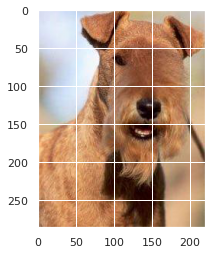

In [25]:
# Randomly test an image from the test set

# model.load_weights('dog_breed_classifier.h5')


imageno=np.random.random_integers(low=0, high=test_generator.samples)

name = test_generator.filepaths[imageno]
print(name)
plt.imshow(mpimg.imread(name))

img = Image.open(test_generator.filepaths[imageno]).resize((targetx, targety))
probabilities = new_model.predict(preprocess_input(np.expand_dims(img, axis=0)))
breed_list = tuple(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))

for i in probabilities[0].argsort()[-5:][::-1]: 
    print(probabilities[0][i], "  :  " , breed_list[i])

# Classification report

In [26]:
test_generator.reset() 

In [27]:
%time
predictions = new_model.predict_generator(test_generator, steps=len(test_generator)) 

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [28]:
%time
y = np.argmax(predictions, axis=1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [29]:
%time
print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Classification Report
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.21      0.47      0.29        30
              n02085782-Japanese_spaniel       0.57      0.62      0.60        37
                   n02085936-Maltese_dog       0.43      0.70      0.53        50
                      n02086079-Pekinese       0.33      0.48      0.39        29
                      n02086240-Shih-Tzu       0.22      0.52      0.31        42
              n02086646-Blenheim_spaniel       0.44      0.62      0.52        37
                      n02086910-papillon       0.36      0.69      0.48        39
                   n02087046-toy_terrier       0.35      0.24      0.28        34
           n02087394-Rhodesian_ridgeback       0.22      0.21      0.21        34
                  n02088094-Afghan_hound       0.72      0.66      0.69        47
           

# Confusion matrix

In [30]:
test_generator.classes

array([  0,   0,   0, ..., 119, 119, 119], dtype=int32)

In [31]:
len(test_generator.classes)

4072

In [32]:
test_generator.class_indices

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terr

In [33]:
classnum_toclasslabel = dict(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))

In [34]:
test_labels = [classnum_toclasslabel[k] for k in test_generator.classes]

In [35]:
predicted_test_labels = [classnum_toclasslabel[k] for k in y]

Confusion Matrix


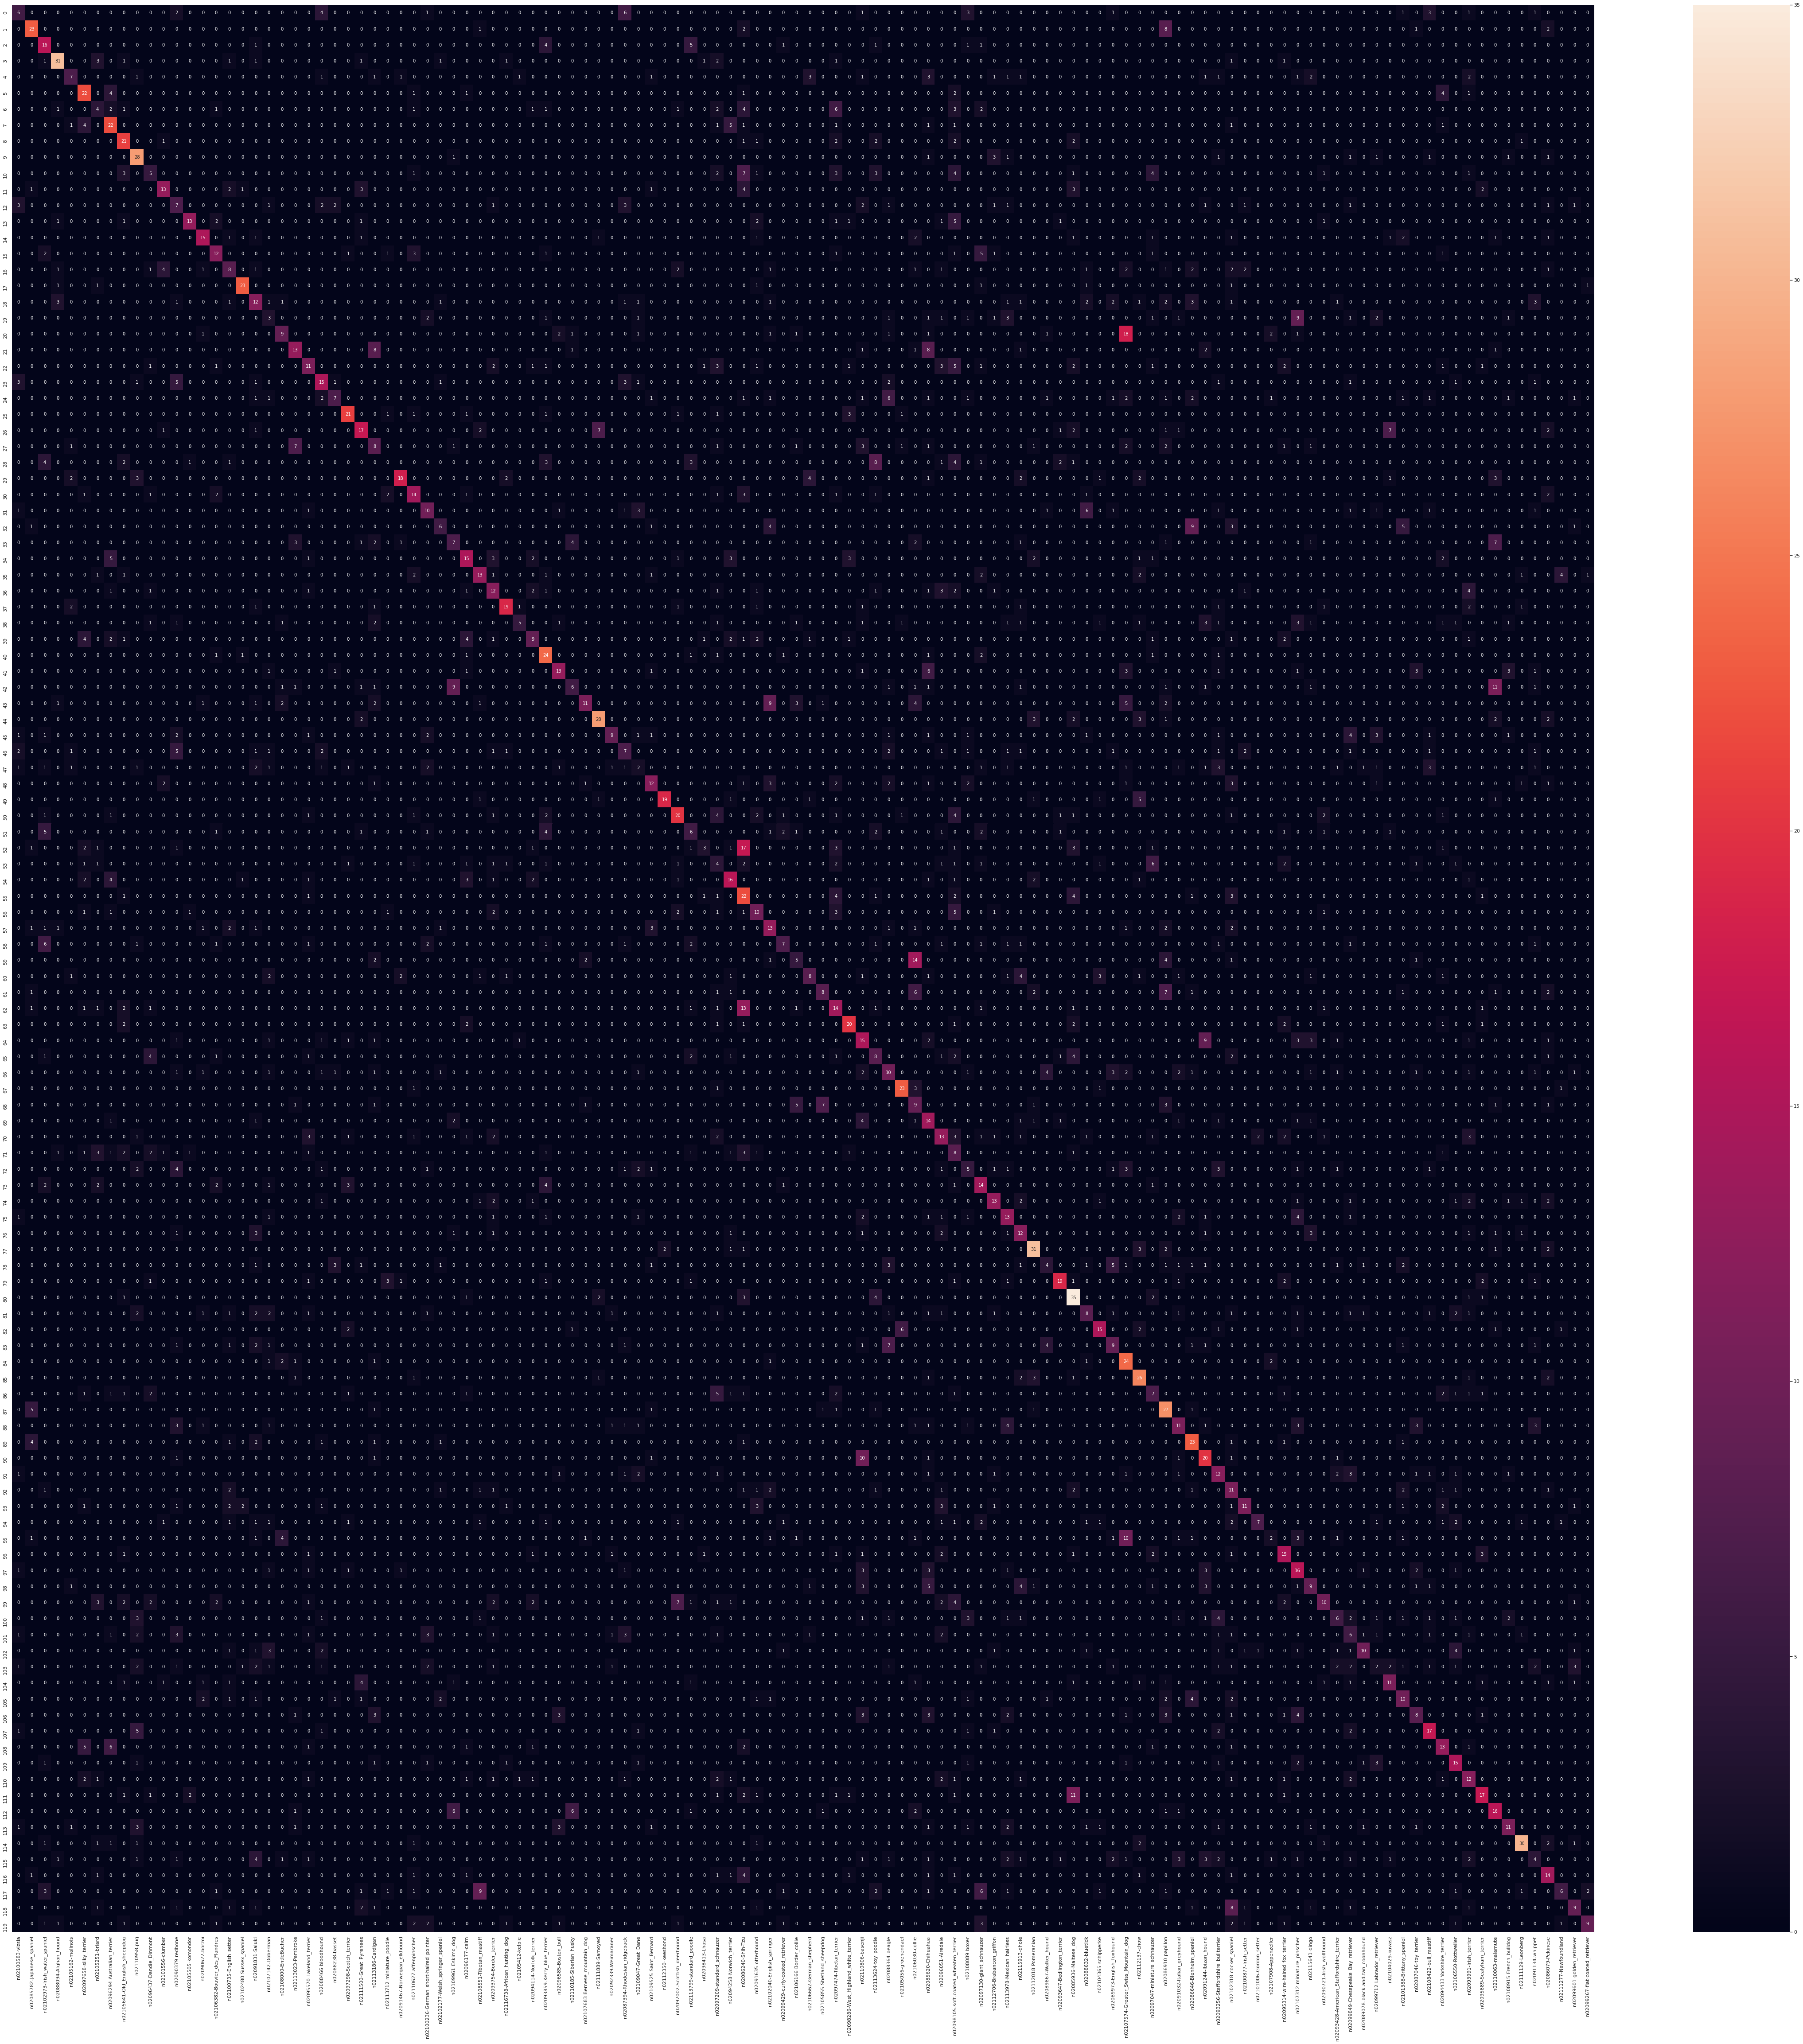

In [36]:
print('Confusion Matrix')
cm = confusion_matrix(test_labels, predicted_test_labels, labels=list(set(test_labels)))
df = pd.DataFrame(cm, columns=list(set(test_labels)))
plt.figure(figsize=(80,80))
sn.heatmap(df, annot=True)

# Error analysis

Text(0.5, 1.0, 'Top misclassed pairs (actual / predicted)')

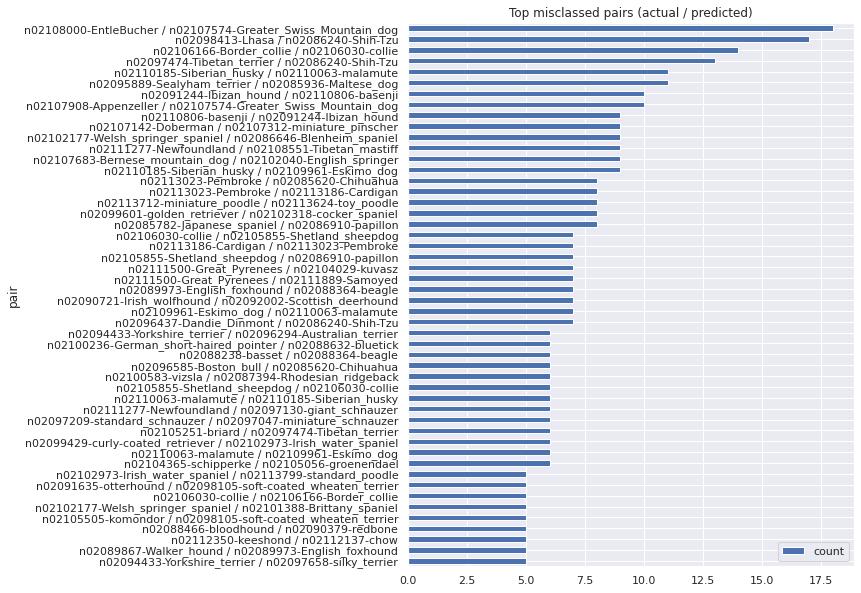

In [37]:
df_predictions_compare = pd.DataFrame({'actual': test_labels, 'pred': predicted_test_labels})
df_predictions_compare['count'] = 1


misclass_df = df_predictions_compare[df_predictions_compare['actual'] != df_predictions_compare['pred']].groupby(['actual', 'pred']).sum().sort_values(['count'], ascending=False).reset_index()
misclass_df['pair'] = misclass_df['actual'] + ' / ' + misclass_df['pred']
misclass_df = misclass_df[['pair', 'count']].take(range(50))
misclass_df.sort_values(['count']).plot.barh(figsize=(8, 10), x='pair')
plt.title('Top misclassed pairs (actual / predicted)')

# Show samples from misclassed breeds

In [38]:
misclassed_pairs_array = misclass_df['pair'].str.split('/')
import matplotlib.image as mpimg
#plt.imshow(mpimg.imread('MyImage.png'))

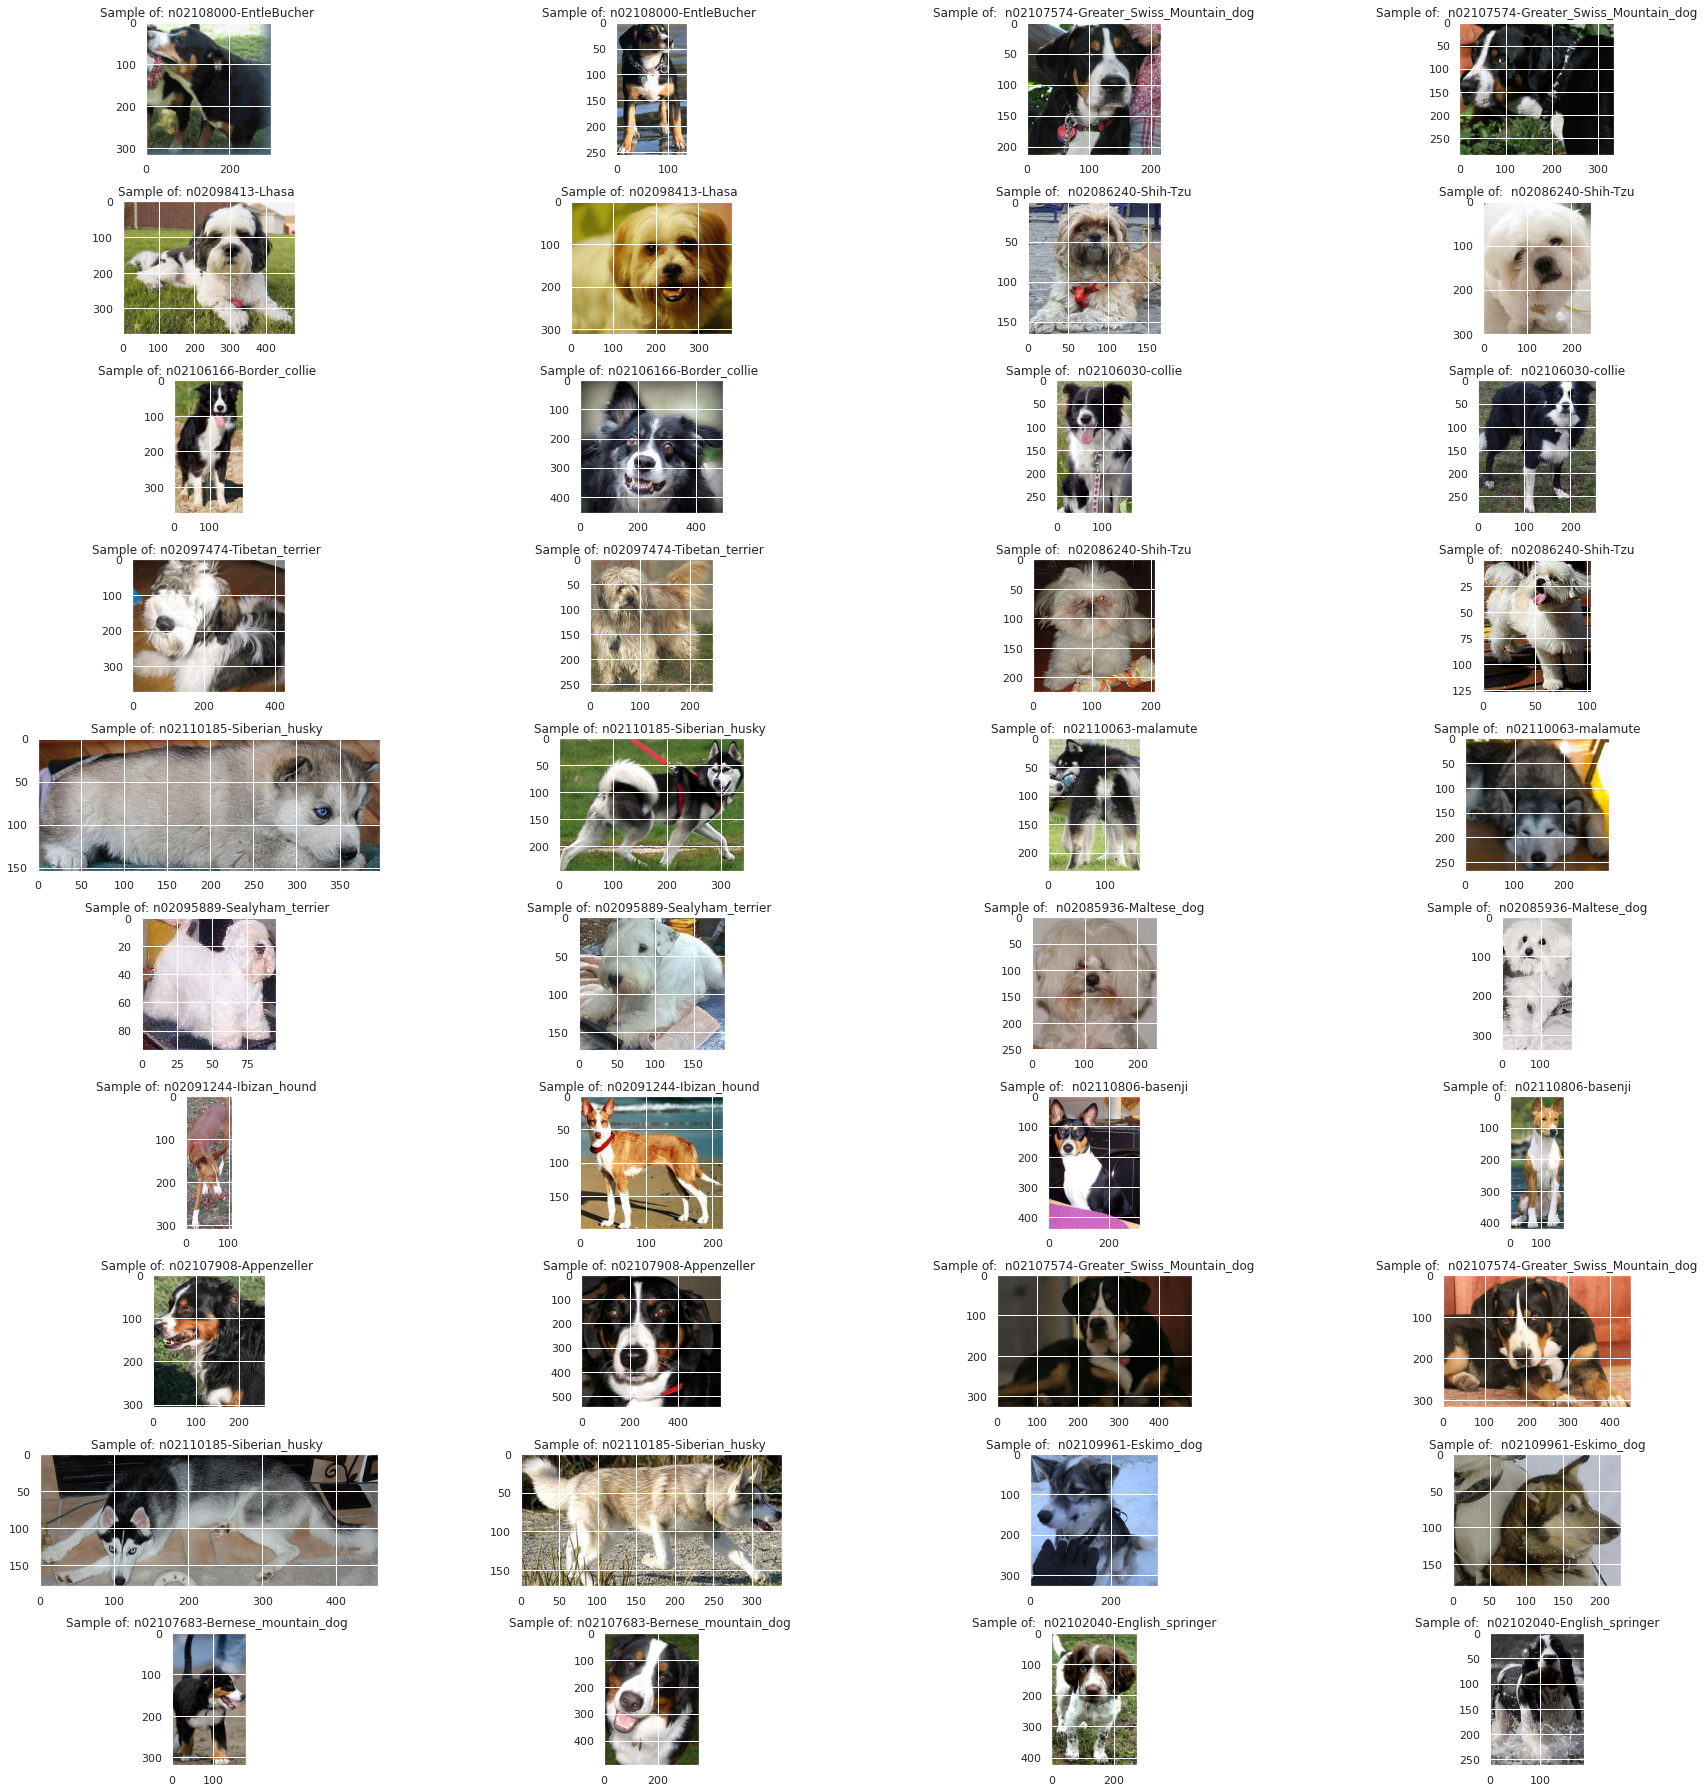

In [39]:
rows = 10
cols = 4
size = 25

misclassed_indice = 0

fig,ax=plt.subplots(rows,cols)
fig.set_size_inches(size,size)

i = 0
j = 0
plt.rcParams["axes.grid"] = False
for misclassed_pair in misclassed_pairs_array:
    if (i < rows):
        actual_indices = [ind for ind,x in enumerate(test_labels) if x == misclassed_pair[0].strip()] 
        predicted_indices = [ind for ind,x in enumerate(test_labels) if x == misclassed_pair[1].strip()] 

        misclassed_pair0 = misclassed_pair[0]
        misclassed_pair1 = misclassed_pair[1]

        rand_indices_actual = np.random.default_rng().choice(len(actual_indices), size=2, replace=False)
        rand_indices_predicted = np.random.default_rng().choice(len(predicted_indices), size=2, replace=False)
        
        plt.grid(None)
        ax[i,0].imshow(mpimg.imread(test_generator.filepaths[actual_indices[rand_indices_actual[0]]]))
        plt.grid(None)
        ax[i,1].imshow(mpimg.imread(test_generator.filepaths[actual_indices[rand_indices_actual[1]]]))
        plt.grid(None)
        ax[i,2].imshow(mpimg.imread(test_generator.filepaths[predicted_indices[rand_indices_predicted[0]]]))
        plt.grid(None)
        ax[i,3].imshow(mpimg.imread(test_generator.filepaths[predicted_indices[rand_indices_predicted[1]]]))
        plt.grid(None)


        ax[i,0].set_title(f'Sample of: {misclassed_pair0}')
        ax[i,1].set_title(f'Sample of: {misclassed_pair0}')
        ax[i,2].set_title(f'Sample of: {misclassed_pair1}')
        ax[i,3].set_title(f'Sample of: {misclassed_pair1}')

        i += 1
        misclassed_indice += 1
        
plt.tight_layout()

../input/stanford-dogs-dataset/images/Images/n02106166-Border_collie/n02106166_1032.jpg
0.41515595   :   (80, 'n02106030-collie')
0.33837283   :   (81, 'n02106166-Border_collie')
0.1408115   :   (88, 'n02107683-Bernese_mountain_dog')
0.053036775   :   (6, 'n02086910-papillon')
0.018285336   :   (97, 'n02109961-Eskimo_dog')


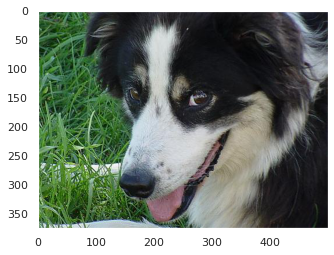

In [40]:
name = '../input/stanford-dogs-dataset/images/Images/n02106166-Border_collie/n02106166_1032.jpg'
print(name)
plt.imshow(mpimg.imread(name))

img = Image.open(name).resize((targetx, targety))
probabilities = new_model.predict(preprocess_input(np.expand_dims(img, axis=0)))
breed_list = tuple(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))

for i in probabilities[0].argsort()[-5:][::-1]: 
    print(probabilities[0][i], "  :  " , breed_list[i])

../input/stanford-dogs-dataset/images/Images/n02099712-Labrador_retriever/n02099712_1383.jpg
0.29365528   :   (71, 'n02104029-kuvasz')
0.29274765   :   (57, 'n02099712-Labrador_retriever')
0.056383103   :   (65, 'n02101556-clumber')
0.056028202   :   (105, 'n02111500-Great_Pyrenees')
0.050759237   :   (21, 'n02091134-whippet')


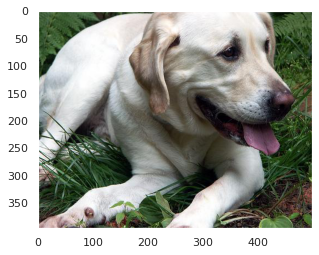

In [41]:
name = '../input/stanford-dogs-dataset/images/Images/n02099712-Labrador_retriever/n02099712_1383.jpg'
print(name)
plt.imshow(mpimg.imread(name))

img = Image.open(name).resize((targetx, targety))
probabilities = new_model.predict(preprocess_input(np.expand_dims(img, axis=0)))
breed_list = tuple(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))

for i in probabilities[0].argsort()[-5:][::-1]: 
    print(probabilities[0][i], "  :  " , breed_list[i])

../input/stanford-dogs-dataset/images/Images/n02104029-kuvasz/n02104029_1206.jpg
0.52670336   :   (81, 'n02106166-Border_collie')
0.1402305   :   (6, 'n02086910-papillon')
0.11332486   :   (79, 'n02105855-Shetland_sheepdog')
0.041707624   :   (80, 'n02106030-collie')
0.03647106   :   (5, 'n02086646-Blenheim_spaniel')


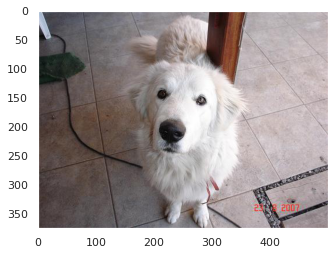

In [42]:
name = '../input/stanford-dogs-dataset/images/Images/n02104029-kuvasz/n02104029_1206.jpg'
print(name)
plt.imshow(mpimg.imread(name))

img = Image.open(name).resize((targetx, targety))
probabilities = new_model.predict(preprocess_input(np.expand_dims(img, axis=0)))
breed_list = tuple(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))

for i in probabilities[0].argsort()[-5:][::-1]: 
    print(probabilities[0][i], "  :  " , breed_list[i])

../input/stanford-dogs-dataset/images/Images/n02106550-Rottweiler/n02106550_10222.jpg
0.4453824   :   (13, 'n02088632-bluetick')
0.17843784   :   (83, 'n02106550-Rottweiler')
0.0909211   :   (14, 'n02089078-black-and-tan_coonhound')
0.0717182   :   (86, 'n02107312-miniature_pinscher')
0.056428812   :   (10, 'n02088238-basset')


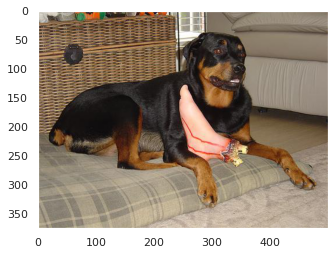

In [43]:
name = '../input/stanford-dogs-dataset/images/Images/n02106550-Rottweiler/n02106550_10222.jpg'
print(name)
plt.imshow(mpimg.imread(name))

img = Image.open(name).resize((targetx, targety))
probabilities = new_model.predict(preprocess_input(np.expand_dims(img, axis=0)))
breed_list = tuple(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))

for i in probabilities[0].argsort()[-5:][::-1]: 
    print(probabilities[0][i], "  :  " , breed_list[i])

../input/stanford-dogs-dataset/images/Images/n02097658-silky_terrier/n02097658_10020.jpg
0.6993263   :   (42, 'n02096294-Australian_terrier')
0.08788225   :   (35, 'n02094258-Norwich_terrier')
0.08486104   :   (50, 'n02097658-silky_terrier')
0.055630308   :   (36, 'n02094433-Yorkshire_terrier')
0.033965707   :   (41, 'n02096177-cairn')


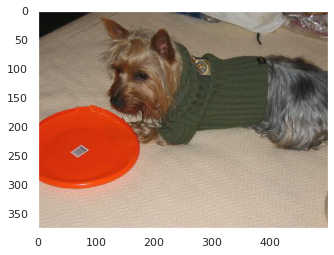

In [44]:
name = '../input/stanford-dogs-dataset/images/Images/n02097658-silky_terrier/n02097658_10020.jpg'
print(name)
plt.imshow(mpimg.imread(name))

img = Image.open(name).resize((targetx, targety))
probabilities = new_model.predict(preprocess_input(np.expand_dims(img, axis=0)))
breed_list = tuple(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))

for i in probabilities[0].argsort()[-5:][::-1]: 
    print(probabilities[0][i], "  :  " , breed_list[i])


../input/stanford-dogs-dataset/images/Images/n02111889-Samoyed/n02111889_1363.jpg
0.999567   :   (106, 'n02111889-Samoyed')
0.00025243202   :   (98, 'n02110063-malamute')
0.0001193196   :   (71, 'n02104029-kuvasz')
4.4738794e-05   :   (105, 'n02111500-Great_Pyrenees')
9.8330775e-06   :   (81, 'n02106166-Border_collie')


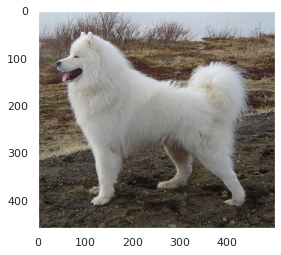

In [45]:
name = '../input/stanford-dogs-dataset/images/Images/n02111889-Samoyed/n02111889_1363.jpg'
print(name)
plt.imshow(mpimg.imread(name))

img = Image.open(name).resize((targetx, targety))
probabilities = new_model.predict(preprocess_input(np.expand_dims(img, axis=0)))
breed_list = tuple(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))

for i in probabilities[0].argsort()[-5:][::-1]: 
    print(probabilities[0][i], "  :  " , breed_list[i])


